# Get pitch and yaw Angles

In [27]:
import numpy as np
import cv2

# Define the path to the labeled videos and corresponding label files
labels_path = '../folder/label_14/'

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# nparay for all angles
angles_labeled = []

# frames
frames = []

# Initialize an array to store the pitch and yaw angles for each frame
# angles = np.zeros((num_frames * 5, 2))
angles = []
angles_lstm = []
angles_reset = []

# Load the labeled videos and extract the pitch and yaw angles for each frame
for i in range(4):

    # Load the label file
    labels = np.loadtxt(labels_path + str(i) + '.txt')
    angles_reset = np.zeros((num_frames, 2))

    lenght_label = len(labels)
    diff_lenght = num_frames - lenght_label

    # Iterate over each frame in the video
    for j in range(lenght_label):

        # Estimate the pitch and yaw angles for the current frame using the labels
        pitch = labels[j, 0]
        yaw = labels[j, 1]

        angles.append((pitch,yaw))
        angles_reset[j] = (pitch,yaw)


    if diff_lenght > 0:
        for k in range(diff_lenght):
            angles.append((None,None))
            angles_reset[j] = (None,None)

    angles_lstm.append(angles_reset)
    # Print the shape of the angles array for verification
    #print(f"Angles shape for video {i}: {angles.shape}")

# Convert the list of frames to a numpy array
angles_lstm = np.array(angles_lstm, dtype = np.float32)
print(f"Frames shape for video LSTM : {angles_lstm.shape}")

Frames shape for video LSTM : (4, 1200, 2)


In [25]:
import cv2
file_path = "../folder/label_14/0.hevc"  # change to your own video path
vid = cv2.VideoCapture(file_path)
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)
print(height/7, width/7)

124.85714285714286 166.28571428571428


## Preprocess and normalize function for a frame

In [28]:
import cv2
import numpy as np

# Define the desired width and height of the frames after resizing
width = 166
height = 125

# Define the normalization parameters
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the intrinsic camera matrix
K = np.array([[910, 0, 0],
              [0, 910, 0],
              [0, 0, 1]])

# Define a function to preprocess a frame
def preprocess_frame(frame):
    # Undistort the frame using the intrinsic camera matrix
    undistorted_frame = cv2.undistort(frame, K, None)

    # Resize the frame to the desired dimensions
    resized_frame = cv2.resize(undistorted_frame, (width, height))

    # grayscale image
    resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2GRAY)

    # bgr
    #resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2BGR)

    # HSV
    #resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_RGB2HSV)
    # V value = 0
    #resized_frame[..., 2] = resized_frame[..., 2] * 0

    # Convert the frame to float32 data type
    normalized_frame = resized_frame.astype(np.float32)

    # Normalize the frame using the defined mean and standard deviation
    normalized_frame /= 255.0
    #normalized_frame -= mean
    #normalized_frame /= std

    return normalized_frame

# Get and preprocess Labeled Frame 

In [29]:
# Define the path to the labeled videos
videos_path = '../folder/label_14/'


# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# Define a default frame to use for filling in missing frames
default_frame = np.zeros((height, width, 3), dtype=np.float32)

# Initialize a list to store the frames for each video
frames_list = []
frames_lstm = []

# Iterate over each video
for i in range(4):
    # Load the video
    video = cv2.VideoCapture(videos_path + str(i) + '.hevc')
    frames_reset = np.zeros((height, width, 3), dtype=np.float32)
    # Initialize an empty list to store the frames for the current video
    frames = []

    # Iterate over each frame in the video
    for j in range(num_frames):
        # Read the frame
        ret, frame = video.read()

        # Check if the frame was successfully read
        if not ret:
            # If the frame was not read, use the default frame instead
            frame = default_frame

        frame = preprocess_frame(frame)
        
        # Containe number of frames per video
        frames.append(frame)
        
        # Contain number of frames total
        frames_list.append(frame)

    # Release the video object
    video.release()

    frames_lstm.append(frames)


# Convert the list of frames for LSTM to a numpy array
frames_lstm = np.array(frames_lstm)
print(f"Frames shape for video LSTM : {frames_lstm.shape}")


# Print the shape of the frames list for verification
print(f"Frames shape: {len(frames_list)} videos, {len(frames_list[0])} frames per video, {len(frames_list[0])}x{len(frames_list[0][0])} pixels")


Frames shape for video LSTM : (4, 1200, 125, 166)
Frames shape: 4800 videos, 125 frames per video, 125x166 pixels


* Delete NaN data

In [8]:
# Find the indices where either pitch or yaw angle is nan
nan_idx = np.where(np.isnan(angles_lstm[:,:,0]) | np.isnan(angles_lstm[:,:,1]))

# Delete the corresponding rows from frames_array_labeled and angles_array_labeled
angles_lstm = np.delete(angles_lstm, nan_idx[1], axis=1)
frames_lstm = np.delete(frames_lstm, nan_idx[1], axis=1)

# Print the shape of the frames and angles arrays after removing NaN values
print(f"Frames shape: {frames_lstm.shape}")
print(f"Angles shape: {angles_lstm.shape}")

Frames shape: (2, 1200, 100, 100, 3)
Angles shape: (2, 1200, 2)


* Replace NaN by 0

In [30]:
# Find the indices where either pitch or yaw angle is nan
nan_idx = np.where(np.isnan(angles_lstm[:,:,0]) | np.isnan(angles_lstm[:,:,1]))

# Replace NaN values with 0 in angles_lstm
angles_lstm[np.isnan(angles_lstm)] = 0

# Print the shape of the frames and angles arrays after replacing NaN values with 0
print(f"Frames shape: {frames_lstm.shape}")
print(f"Angles shape: {angles_lstm.shape}")

Frames shape: (4, 1200, 125, 166)
Angles shape: (4, 1200, 2)


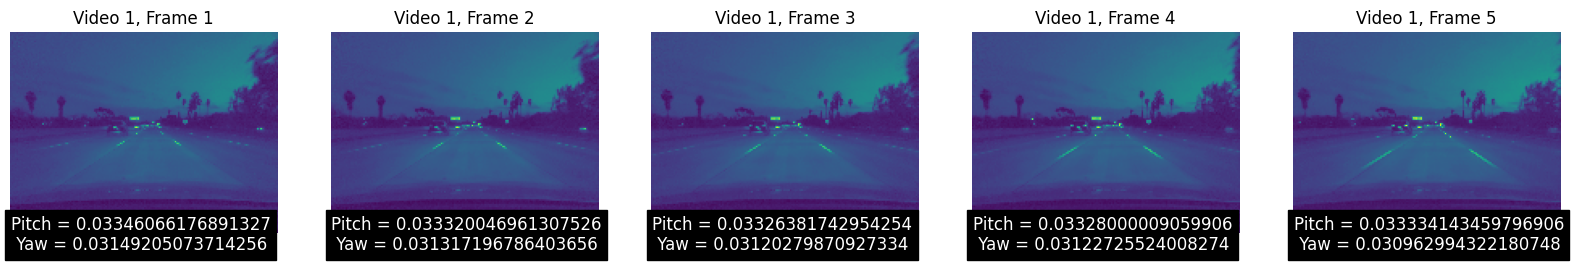

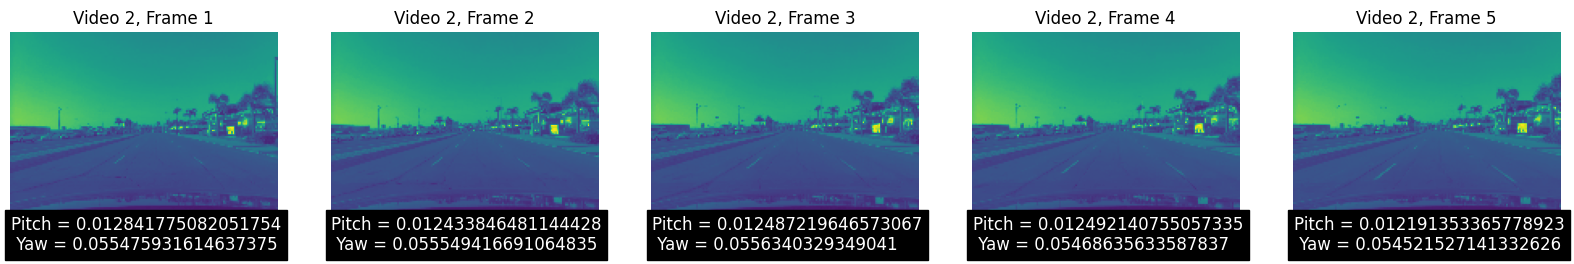

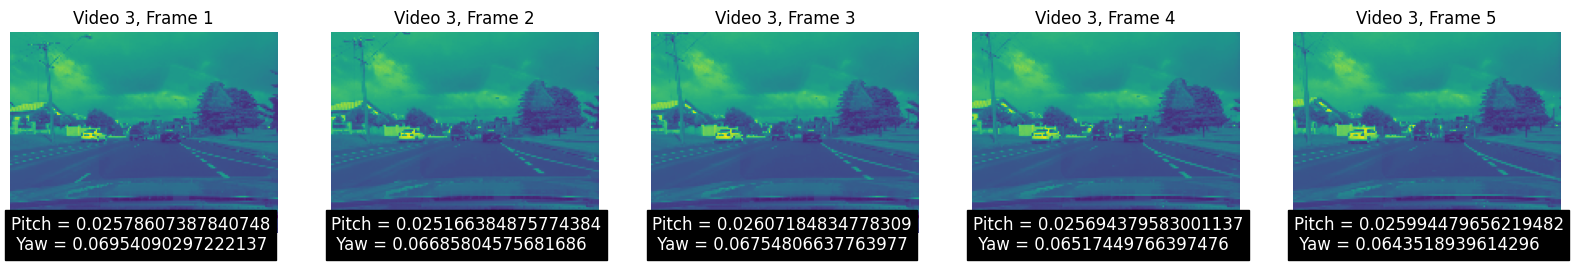

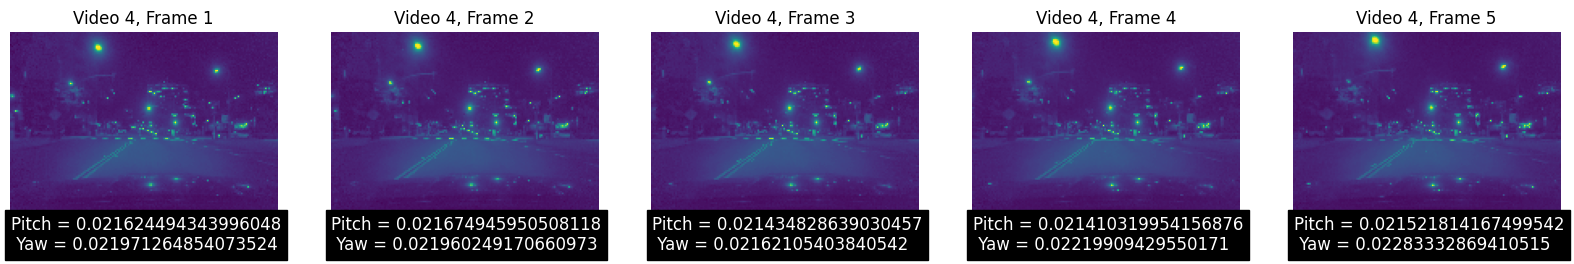

In [31]:
import matplotlib.pyplot as plt

# Define the number of frames to plot
num_frames_to_plot = 5

# Plot the first 5 frames of each video
for i in range(frames_lstm.shape[0]):  # loop over videos
    plt.figure(figsize=(20, 10))
    for j in range(num_frames_to_plot):  # loop over frames
        pitch = angles_lstm[i, j, 0]
        yaw = angles_lstm[i, j, 1]
        plt.subplot(1, num_frames_to_plot, j+1)
        plt.imshow(frames_lstm[i, j, ...])
        plt.axis('off')
        plt.title(f'Video {i+1}, Frame {j+1}')
        plt.text(0, frames_lstm[i, j, ...].shape[0]+10, f"Pitch = {pitch}\n Yaw = {yaw}", fontsize=12, color='white', backgroundcolor='black')
    plt.show()


* Plot some frames

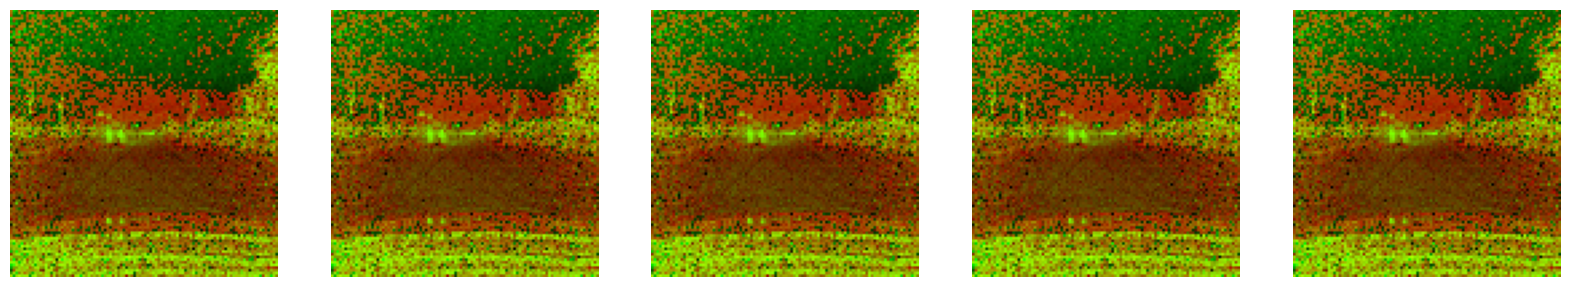

In [11]:
import matplotlib.pyplot as plt

# Define the number of frames to plot
num_frames_to_plot = 5

# Create a figure with multiple subplots
fig, axes = plt.subplots(1, num_frames_to_plot, figsize=(20, 10))

# Plot the first num_frames_to_plot frames from the list
for i in range(num_frames_to_plot):
    axes[i].imshow(frames_list[0])
    axes[i].axis('off')

# Show the plot
plt.show()

# WandB

In [12]:
import wandb
from wandb.keras import WandbCallback

!wandb login 9ac325ccaea24e6579ccfd48050d0069010acb93

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\youss/.netrc


In [13]:

# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="calib_challenge",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 32,
        "activation_1": "relu",
        "layer_2": 64,
        "activation_2": "relu",
        "layer_2": 128,
        "dense": 256,
        "activation_3": "relu",
        "dropout": 0.8,
        "dense": 2,
        "activation_4": "relu",
        "optimizer": "adam",
        "loss": "mse",
        "metric": "accuracy",
        "epoch": 20,
        "batch_size": 32
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ykhouchaf. Use `wandb login --relogin` to force relogin


# Convolutional neural network (CNN)

* classic

In [14]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape = (100, height, width, 3)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN model
# Create the model
model = Sequential()
model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization(center=True, scale=True))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

# Compile the model with the mean squared error loss and the Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])


* Classic with more layers

In [15]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape = (224, 224, 3)

# Input shape if gray 
input_shape_gray = (224, 224, 1)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN model
model = keras.Sequential([
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_outputs, activation='linear')
])

# Compile the model with the mean squared error loss and the Adam optimizer
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


* LSTM

In [16]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape_frames = (None, 224, 224, 3)
output_shape_angles = (None, None, 2)

# Define if gray or color
gray = 1
color = 3

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the LSTM model
model = keras.Sequential([
    keras.Input(shape=input_shape_frames),
    keras.layers.TimeDistributed(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), padding="same", activation="relu")),
    keras.layers.TimeDistributed(keras.layers.BatchNormalization()),
    keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu")),
    keras.layers.TimeDistributed(keras.layers.BatchNormalization()),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(units=32, return_sequences=True, activation="tanh"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_outputs, activation=None)
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


In [17]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape_frames = (None, 224, 224, 3)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the LSTM model
model = keras.Sequential([
    keras.layers.TimeDistributed(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"), input_shape=input_shape_frames),
    keras.layers.TimeDistributed(keras.layers.BatchNormalization()),
    keras.layers.TimeDistributed(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")),
    keras.layers.TimeDistributed(keras.layers.BatchNormalization()),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(num_outputs)
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3211264,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [32]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape_frames = (5, height, width, 3)

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN-LSTM model
model = keras.Sequential([
    keras.layers.TimeDistributed(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), input_shape=input_shape_frames),
    keras.layers.TimeDistributed(keras.layers.BatchNormalization()),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(32, return_sequences=True, activation="relu"),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(16, activation="relu"),
    keras.layers.TimeDistributed(keras.layers.Dense(num_outputs, activation='softmax'), name = 'output')
    #keras.layers.Dense(num_outputs),                 
])   

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

: 

In [26]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape_frames = (5, 224, 224, 3)

# Define if gray or color
gray = 1
color = 3

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the CNN-LSTM model
model = keras.Sequential([
    keras.layers.TimeDistributed(keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"), input_shape=input_shape_frames),
    keras.layers.TimeDistributed(keras.layers.Flatten()),
    keras.layers.LSTM(32, return_sequences=False, activation="relu"),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_outputs),                 
])   

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

ResourceExhaustedError: {{function_node __wrapped__StatelessRandomUniformV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[3154176,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessRandomUniformV2]

In [ ]:
from tensorflow import keras

# Define the input shape of the frames (assumed to be the same for all frames)
input_shape_frames = (None, 224, 224, 3)

# Define if gray or color
gray = 1
color = 3

# Define the number of output nodes (2 for pitch and yaw)
num_outputs = 2

# Define the LSTM model
model = keras.Sequential([
    keras.Input(shape=input_shape_frames),
    keras.layers.ConvLSTM2D(filters=32, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=False, activation="relu"),
    keras.layers.BatchNormalization(),
    #keras.layers.Conv3D(filters=color, kernel_size=(3, 3, 3), padding="same", activation="sigmoid"),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(num_outputs)
    keras.layers.TimeDistributed(keras.layers.Dense(units=num_outputs, activation=None))
])

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


ResourceExhaustedError: {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2]

* RNN

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 98, 98, 64)    1792      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 98, 98, 64)    256       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 614656)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 5, 32)             78680192  
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                        

# Train

* GPU train if no using model with transfer learning

In [19]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# frees up any memory that was used during last session
tf.keras.backend.clear_session()

# Split the labeled video data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(frames_array_labeled, angles_array_labeled, test_size=0.2, random_state=1)

# Train the model on the training set using the fit() function and evaluate it with evaluate()
with tf.device('/GPU:0'):
    #history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[WandbCallback()])
    history = model.fit(x_train, y_train, batch_size=16, epochs=20, validation_data=(x_val, y_val))
    loss = model.evaluate(x_val, y_val)
print('Validation Loss:', loss)

Epoch 1/20
191/191 [==============================] - 56s 274ms/step - loss: 0.0736 - accuracy: 0.5336 - val_loss: 0.0011 - val_accuracy: 0.5812
Epoch 2/20
191/191 [==============================] - 56s 293ms/step - loss: 0.0031 - accuracy: 0.5430 - val_loss: 1.8759e-04 - val_accuracy: 0.5812
Epoch 3/20
 17/191 [=>............................] - ETA: 45s - loss: 0.0013 - accuracy: 0.5110

KeyboardInterrupt: 

* LSTM Train

In [17]:
print(frames_lstm.shape[1])

1113


In [16]:
# Define the number of training samples
num_training_samples = 1000
num_videos = 4

# Initialize x_train and y_train arrays
x_train = np.zeros((num_videos, num_training_samples, height, width, 3))
y_train = np.zeros((num_videos, num_training_samples, 2))
x_val = np.zeros((num_videos, frames_lstm.shape[1] - num_training_samples, height, width, 3))
y_val = np.zeros((num_videos, frames_lstm.shape[1] - num_training_samples, 2))

# Loop over the labeled video data
for i in range(frames_lstm.shape[0]):
    # Split the frames and angles data into training sets
    x = frames_lstm[i][:num_training_samples]
    y = angles_lstm[i][:num_training_samples]
    x_train[i] = x
    y_train[i] = y
    
    # Split the frames and angles data into validation sets
    x = frames_lstm[i][num_training_samples:]
    y = angles_lstm[i][num_training_samples:]
    x_val[i] = x
    y_val[i] = y
    
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)


(4, 1000, 100, 100, 3)
(4, 200, 100, 100, 3)
(4, 1000, 2)
(4, 200, 2)


In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# frees up any memory that was used during last session
tf.keras.backend.clear_session()

# Train the model on the training set using the fit() function and evaluate it with evaluate()
with tf.device('/GPU:0'):
    #history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[WandbCallback()])
    history = model.fit(x_train, y_train, batch_size=4, epochs=20, validation_data=(x_val, y_val))
    loss = model.evaluate(x_val, y_val)
print('Validation Loss:', loss)

* Reshape for model (None, 5, x, y, color)

In [17]:
import numpy as np

# Define the window size
window_size = 5

# Create a list to store the sequences for x_train and y_train
frame_sequences = []
angle_sequences = []

# Loop through each video
for i in range(x_train.shape[0]): # loop through the videos
    # Determine the number of sequences that can be created for this video
    num_sequences = x_train.shape[1] - window_size + 1
    
    # Create sequences by sliding the window
    for j in range(num_sequences):
        # Extract the sequence of x_train and y_train for this window
        frame_sequence = x_train[i, j:j+window_size]
        angle_sequence = y_train[i, j:j+window_size]
        
        # Append the sequence to the list
        frame_sequences.append(frame_sequence)
        angle_sequences.append(angle_sequence)
        
# Convert the list of sequences into numpy arrays
x_train_reshape = np.array(frame_sequences)
y_train_reshape = np.array(angle_sequences)

# Print the shape of the sequences arrays
print(f"x_train sequence shape: {x_train_reshape.shape}")
print(f"y_train sequence shape: {y_train_reshape.shape}")


x_train sequence shape: (3984, 5, 100, 100, 3)
y_train sequence shape: (3984, 5, 2)


In [18]:
import numpy as np

# Define the window size
window_size = 5

# Create a list to store the sequences for x_val and y_val
frame_sequences = []
angle_sequences = []

# Loop through each video
for i in range(x_val.shape[0]): # loop through the videos
    # Determine the number of sequences that can be created for this video
    num_sequences = x_val.shape[1] - window_size + 1
    
    # Create sequences by sliding the window
    for j in range(num_sequences):
        # Extract the sequence of x_val and y_val for this window
        frame_sequence = x_val[i, j:j+window_size]
        angle_sequence = y_val[i, j:j+window_size]
        
        # Append the sequence to the list
        frame_sequences.append(frame_sequence)
        angle_sequences.append(angle_sequence)
        
# Convert the list of sequences into numpy arrays
x_val_reshape = np.array(frame_sequences)
y_val_reshape = np.array(angle_sequences)

# Print the shape of the sequences arrays
print(f"x_val sequence shape: {x_val_reshape.shape}")
print(f"y_val sequence shape: {y_val_reshape.shape}")


x_val sequence shape: (784, 5, 100, 100, 3)
y_val sequence shape: (784, 5, 2)


In [19]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# frees up any memory that was used during last session
tf.keras.backend.clear_session()

# Train the model on the training set using the fit() function and evaluate it with evaluate()
with tf.device('/GPU:0'):
    #history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val), callbacks=[WandbCallback()])
    history = model.fit(x_train_reshape, y_train_reshape, batch_size=8, epochs=20, validation_data=(x_val_reshape, y_val_reshape))
    loss = model.evaluate(x_val_reshape, y_val_reshape)
print('Validation Loss:', loss)

Epoch 1/20
498/498 [==============================] - 53s 84ms/step - loss: 0.4204 - accuracy: 0.5368 - val_loss: 0.4479 - val_accuracy: 0.8191
Epoch 2/20
498/498 [==============================] - 35s 70ms/step - loss: 0.3336 - accuracy: 0.5135 - val_loss: 0.4112 - val_accuracy: 0.6776
Epoch 3/20
498/498 [==============================] - 35s 71ms/step - loss: 0.3104 - accuracy: 0.4824 - val_loss: 0.3123 - val_accuracy: 0.6635
Epoch 4/20
498/498 [==============================] - 35s 70ms/step - loss: 0.2531 - accuracy: 0.4730 - val_loss: 0.2361 - val_accuracy: 0.6293
Epoch 5/20
498/498 [==============================] - 34s 69ms/step - loss: 0.2279 - accuracy: 0.4386 - val_loss: 0.2217 - val_accuracy: 0.6074
Epoch 6/20
132/498 [======>.......................] - ETA: 23s - loss: 0.2280 - accuracy: 0.4400

KeyboardInterrupt: 

* Datagen

In [7]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# frees up any memory that was used during last session
tf.keras.backend.clear_session()

# Split the labeled video data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(frames_array_labeled, angles_array_labeled, test_size=0.2, random_state=1)

# Define data augmentation parameters
data_gen = ImageDataGenerator(brightness_range=(0.75, 1))

# Generate augmented images
augmented_images = data_gen.flow(x_train, y_train, batch_size=32)

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Train the model on the training set using the fit() function and evaluate it with evaluate()
with tf.device('/GPU:0'):
    history = model.fit(x_train, y_train, batch_size=32, epochs=1000, validation_data=(x_val, y_val))
    loss = model.evaluate(x_val, y_val)
print('Validation Loss:', loss)


Epoch 1/1000
96/96 [==============================] - 16s 60ms/step - loss: 0.3323 - mse: 0.3323 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 2/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 3/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0325 - mse: 0.0325 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 6/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 7/1000
96/96 [==============================] - 5s 48ms/step - loss: 0.0157 - mse: 0.0157 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 8/1000
96/96 [==============================] - 5s 48ms/step -

# Finish WandB

In [11]:
wandb.finish()

accuracy,▁▃▄▆▆▅▆▆▆▇▇▅█▇▆█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂█▁▁▁▃
val_loss,█▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▂▁▁▂
accuracy,0.6766
best_epoch,15
best_val_loss,3e-05
epoch,19
loss,8e-05
val_accuracy,0.61518


* Plot

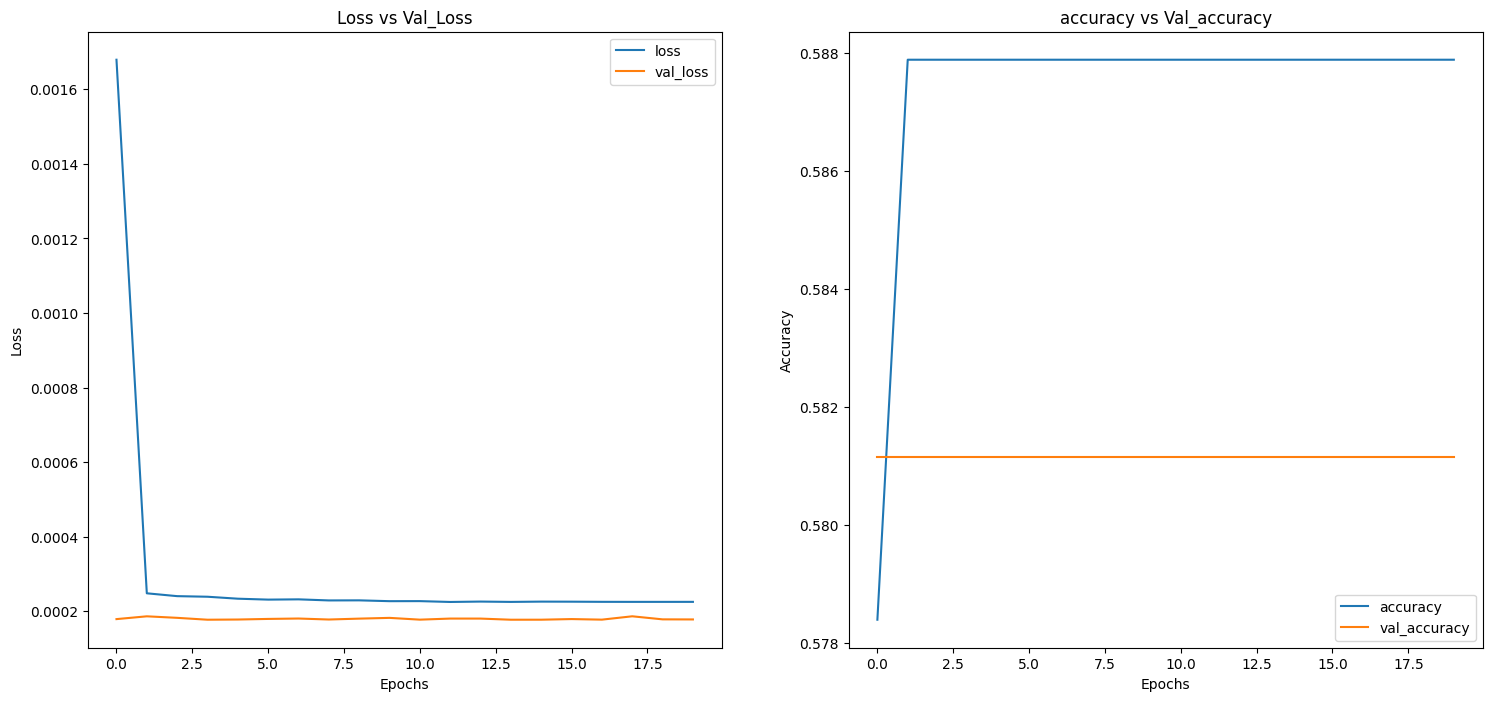

In [16]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot the first subplot with loss and validation loss
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.set_title('Loss vs Val_Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the second subplot with accuracy and validation accuracy
ax2.plot(history.history['accuracy'], label='accuracy')
ax2.plot(history.history['val_accuracy'], label='val_accuracy')
ax2.set_title('accuracy vs Val_accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Display the figure
plt.show()


# Predict

* Predict for one label video and save files

In [17]:
import numpy as np

# Define the path to the labeled videos
videos_path = '../labeled/'

# Define the path to the output files
output_path = '../folder/'

# Define the dimensions of the frames (assumed to be the same for all videos)
frame_width = 1920
frame_height = 1080

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# file
i = 1

# Initialize arrays to store the predicted pitch and yaw angles for each frame in each video
pitch_angles = np.zeros((5, num_frames))
yaw_angles = np.zeros((5, num_frames))


# Load the video
video = cv2.VideoCapture(videos_path + str(i) + '.hevc')

# Initialize an empty list to store the frames for the current video
frames = []

# Iterate over each frame in the video
for j in range(num_frames):
    # Read the frame
    ret, frame = video.read()

    # Check if the frame was successfully read
    if not ret:
        break

    # Preprocess the frame
    frame = preprocess_frame(frame)

    # Make a prediction using the model
    prediction = model.predict(np.expand_dims(frame, axis=0))

    # Extract the pitch and yaw angles from the prediction
    pitch_angle, yaw_angle = prediction[0]

    # Store the pitch and yaw angles in the arrays
    pitch_angles[i, j] = pitch_angle
    yaw_angles[i, j] = yaw_angle

# Release the video object
video.release()

# Write the pitch and yaw angles to files
np.savetxt(output_path + str(i) + '.txt', np.vstack((pitch_angles[i], yaw_angles[i])).T)


1/1 [==============================] - 0s 19ms/step


* Plot my generated angles and initial angles

In [18]:
import numpy as np

# Define the path to the labeled videos and corresponding label files
labels_path = '../folder/'

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# nparay for all angles
angles_predicted_labeled = []
angles_initial_labeled = []

# frames
frames = []

# Initialize an array to store the pitch and yaw angles for each frame
angles = []
i = 1

########################### predicted ###########################

# Load the predicted label file
labels = np.loadtxt(labels_path + str(i) + '.txt')

lenght_label = len(labels)
diff_lenght = num_frames - lenght_label

# Iterate over each frame in the video
for j in range(lenght_label):

    # Estimate the pitch and yaw angles for the current frame using the labels
    pitch = labels[j, 0]
    yaw = labels[j, 1]

    angles.append((pitch,yaw))

if diff_lenght > 0:
    for k in range(diff_lenght):
        angles.append((None,None))

# Convert the list of frames to a numpy array
angles_predicted_labeled = np.array(angles, dtype = np.float32)
print(f"Frames shape for video predicted : {angles_predicted_labeled.shape}")

########################### Labeled ###########################

labels_path = '../labeled/'
angles = []
frames = []
# Load the inital label file
labels = np.loadtxt(labels_path + str(i) + '.txt')

lenght_label = len(labels)
diff_lenght = num_frames - lenght_label

# Iterate over each frame in the video
for j in range(lenght_label):

    # Estimate the pitch and yaw angles for the current frame using the labels
    pitch = labels[j, 0]
    yaw = labels[j, 1]

    angles.append((pitch,yaw))

if diff_lenght > 0:
    for k in range(diff_lenght):
        angles.append((None,None))

# Convert the list of frames to a numpy array
angles_initial_labeled = np.array(angles, dtype = np.float32)
print(f"Frames shape for video labeled : {angles_initial_labeled.shape}")



# Find the indices of the rows containing NaN values in the first and second columns
nan_idx_0 = np.isnan(angles_initial_labeled[:,0])
nan_idx_1 = np.isnan(angles_initial_labeled[:,1])
# Replace the values in the first and second columns with NaN
angles_predicted_labeled[nan_idx_0,0] = np.nan
angles_predicted_labeled[nan_idx_1,1] = np.nan

# Print the shape of the frames and angles arrays after removing NaN values
print(f"Angles predicted: {angles_predicted_labeled.shape}")
print(f"Angles initial: {angles_initial_labeled.shape}")

Frames shape for video predicted : (1200, 2)
Frames shape for video labeled : (1200, 2)
Angles predicted: (1200, 2)
Angles initial: (1200, 2)


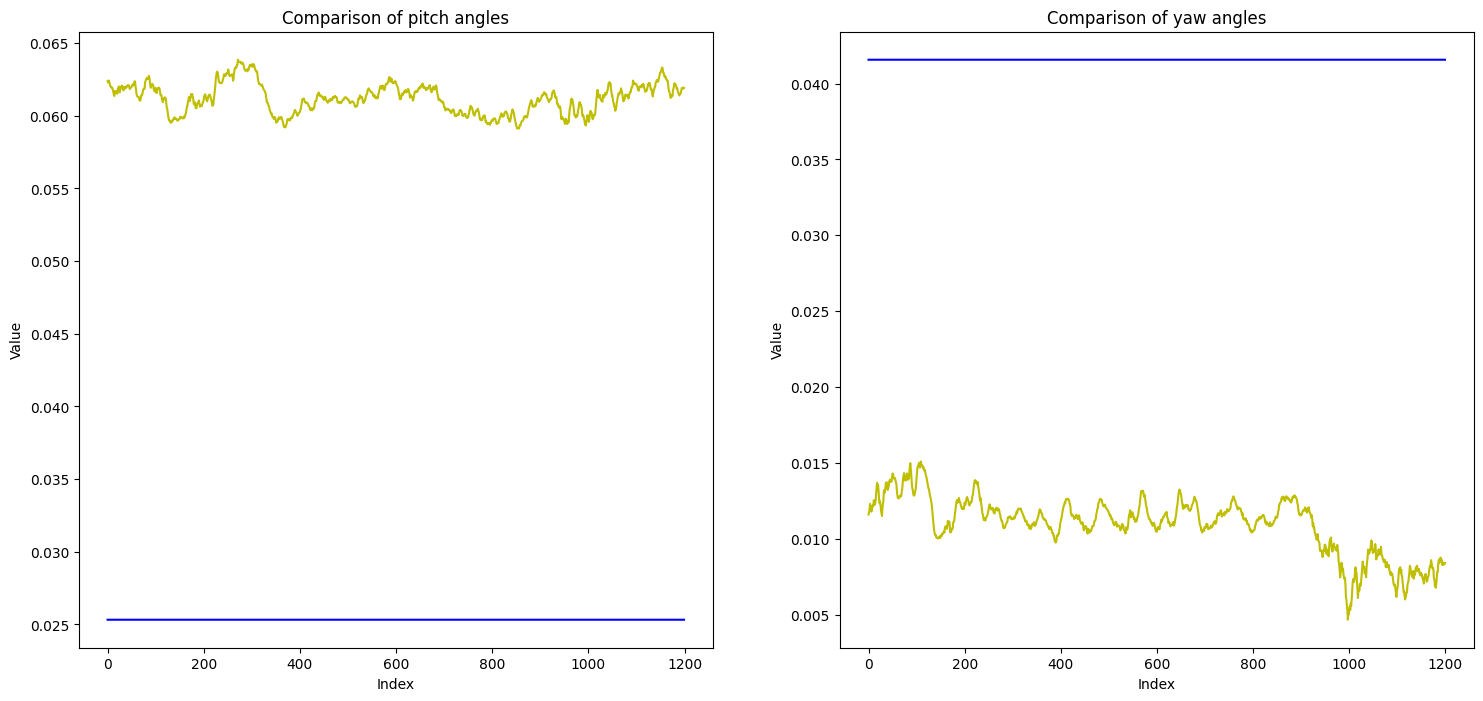

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Define two NumPy arrays for comparison
array1_pitch = angles_predicted_labeled[:, 0]
array2_pitch = angles_initial_labeled[:, 0]

# Plot the two arrays with different colors in the first subplot
ax1.plot(array1_pitch, 'b')
ax1.plot(array2_pitch, 'y')

# Add title and labels for the first subplot
ax1.set_title('Comparison of pitch angles')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')

# Define two NumPy arrays for comparison
array1_yaw = angles_predicted_labeled[:, 1]
array2_yaw = angles_initial_labeled[:, 1]

# Plot the two arrays with different colors in the second subplot
ax2.plot(array1_yaw, 'b')
ax2.plot(array2_yaw, 'y')

# Add title and labels for the second subplot
ax2.set_title('Comparison of yaw angles')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')

# Show the plot
plt.show()


In [14]:
model.save('model_180ep_HV_classic_36%')

INFO:tensorflow:Assets written to: model_180ep_HV_classic_36%\assets


INFO:tensorflow:Assets written to: model_180ep_HV_classic_36%\assets


* Predict for unlabeled videos and save files

In [ ]:
import numpy as np

# Define the path to the unlabeled videos
videos_path = '../unlabeled/'

# Define the path to the output files
output_path = '../folder/outputs/'

# Define the dimensions of the frames (assumed to be the same for all videos)
frame_width = 1920
frame_height = 1080

# Define the number of frames in each video (assumed to be the same for all videos)
num_frames = 1200

# Initialize arrays to store the predicted pitch and yaw angles for each frame in each video
pitch_angles = np.zeros((5, num_frames))
yaw_angles = np.zeros((5, num_frames))

# Iterate over each video
for i in range(5):
    # Load the video
    video = cv2.VideoCapture(videos_path + str(i + 5) + '.hevc')

    # Initialize an empty list to store the frames for the current video
    frames = []

    # Iterate over each frame in the video
    for j in range(num_frames):
        # Read the frame
        ret, frame = video.read()

        # Check if the frame was successfully read
        if not ret:
            break

        # Preprocess the frame
        frame = preprocess_frame(frame)

        # Make a prediction using the model
        prediction = model.predict(np.expand_dims(frame, axis=0))

        # Extract the pitch and yaw angles from the prediction
        pitch_angle, yaw_angle = prediction[0]

        # Store the pitch and yaw angles in the arrays
        pitch_angles[i, j] = pitch_angle
        yaw_angles[i, j] = yaw_angle

    # Release the video object
    video.release()

    # Write the pitch and yaw angles to files
    np.savetxt(output_path + str(i + 5) + '.txt', np.vstack((pitch_angles[i], yaw_angles[i])).T)


In [ ]:
Your plan looks like a good starting point for generating the labels for the unlabeled videos. Here are a few comments on your approach:

1- Loading the labeled videos and extracting the pitch and yaw angles for each frame is a good first step. This will provide you with the training data you need to train your model.

2- Loading the unlabeled videos and extracting the frames is also a good next step.

3- Preprocessing the frames by resizing and normalizing them is a good idea, as this can help improve the accuracy of your model.

4- Building a neural network model that takes in a frame and outputs the estimated pitch and yaw angles is a good approach. You may want to consider using a convolutional neural network (CNN) to learn features from the images, as this can be effective for image-based tasks.

5- Training the model using the labeled video data and evaluating its performance is essential to ensure that your model is accurate and effective. You may want to use metrics such as mean squared error (MSE) or mean absolute error (MAE) to evaluate the performance of your model.

6- Using the trained model to predict the pitch and yaw angles for each frame in the unlabeled videos is a good next step.

7- Saving the predicted pitch and yaw angles in 2D arrays and writing them to files 5.txt to 9.txt is a good final step.

Overall, your plan looks like a good approach to generate the labels for the unlabeled videos. Just keep in mind that it may require some iteration and adjustment based on your results. Good luck with your project!



